In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import os
import glob
import re

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.preprocessing import sequence

Using TensorFlow backend.


In [4]:
from keras import backend as K

In [5]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
path = './train/audio/'

In [7]:
os.chdir(path)

In [9]:
!pip install librosa

    100% |################################| 1.6MB 6.3MB/s eta 0:00:01    17% |#####                           | 266kB 2.2MB/s eta 0:00:01
    100% |################################| 276kB 29.5MB/s ta 0:00:01
    100% |################################| 327kB 29.9MB/s ta 0:00:01
    100% |################################| 3.2MB 9.0MB/s eta 0:00:01
    100% |################################| 16.1MB 1.2MB/s eta 0:00:01   27% |########                        | 4.4MB 50.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for librosa ... done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audiore

In [10]:
import librosa

import numpy as np

import librosa.core
import librosa.display
import librosa.effects

In [11]:
import math
from keras import optimizers

In [12]:
import keras
import keras.utils
import random
import numpy.random
import pickle

In [13]:
import keras.preprocessing.text

In [14]:
from random import shuffle
from sklearn.model_selection import train_test_split

In [15]:
labels = glob.glob('*')

In [16]:
labels = [x for x in labels if not x.startswith("_")]

In [17]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=len(labels))

In [18]:
tokenizer.fit_on_texts(labels)

In [19]:
len(labels)

30

In [20]:
len(tokenizer.texts_to_sequences(labels))

30

In [21]:
files = glob.glob('./*/*.wav')
        
# ignore noises
files = [x for x in files if not x.startswith("_")]

In [22]:
shuffle(files)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(files, files, test_size=.05)

In [24]:
len(X_train), len(X_test)

(61484, 3237)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def mfcc(file):
    data, fs = librosa.load(file, mono=True, sr=16e3)
    trimed, index = librosa.effects.trim(data, top_db=29, frame_length=10)
    # trimed = np.concatenate( (trimed, np.random.ranf(int(5e4) - len(trimed))/1e3), axis=0)
    mfcc = librosa.feature.mfcc(trimed, sr=16e3)
    #return mfcc.shape[1]
    
    pad_width = max_pad - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.reshape((20,16,2))    

In [247]:
def asis(file):
    data, fs = librosa.load(file, mono=True, sr=44e3)
    return data   

In [26]:
def melspec(file):
    data, fs = librosa.load(file, mono=True, sr=44e3)
    D = np.abs(librosa.stft(data))**2
    S = librosa.feature.melspectrogram(S=D)
    return S.reshape(-1)

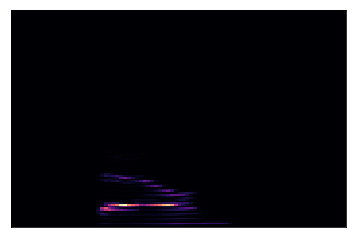

In [143]:
data, fs = librosa.load(files[10004], mono=True, sr=44e3)
#s = librosa.feature.melspectrogram(y=data, sr=fs)

D = np.abs(librosa.stft(data))**2
S = librosa.feature.melspectrogram(S=D)

librosa.display.specshow(S)

In [110]:
data, fs = librosa.load(files[1], mono=True, sr=44e3)

In [156]:
shp = [melspec(x) for x in files[1000:2050]]

In [159]:
min([x[1] for x in shp])

45

In [ ]:
max([ x for x in list(zip(shp, files))])

In [71]:
normal = [ x for x in list(zip(shp, files)) if x[0] <10000]

In [92]:
max_pad = max([x[0] for x in normal])

In [114]:
max_pad = 44000

In [27]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras Sequence dataset'
    
    def __init__(self, files, tokenizer, batch_size=16, maxlen=5e5, n_classes=30, shuffle=True):
        'Initialize class'
        
        self.batch_size = batch_size
        
        # labels
        self.file_to_label = {x:re.findall(r'\./(.*)/(.*)$', x)[0][0] for x in files}
        
        # files
        self.files = files
        
        # params
        self.tokenizer = tokenizer
        self.maxlen = int(maxlen)
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.samples = len(files)
        

    def __len__(self):
        'Returns the number of batches per epoch'
        return math.floor(self.samples/ self.batch_size)
    

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        files = [self.files[random.randint(0, len(self.files)-1)] for x in range(self.batch_size)]
        X, y = self.__data_generation(files)

        return X, y


    def __data_generation(self, files):
        'Generates data containing batch_size samples' 
        
        kernel_size=(256,43,1)
        X = np.empty((self.batch_size, 256, 43, 1), dtype=np.ndarray)
        y = np.empty((self.batch_size), dtype=object)

        # Generate data
        for i, file in enumerate(files):
            # load mfcc
            data = melspec(file)
            
            data = np.concatenate( (data, np.zeros(11008 - len(data))), axis=0)
            
            X[i,] = data.reshape(kernel_size)

            # Store class
            y[i] = self.file_to_label[file]
            # print(y)

        return X, tokenizer.texts_to_matrix(y)

In [28]:
train = DataGenerator(X_train, tokenizer, batch_size=16, shuffle=True)
test = DataGenerator(X_test, tokenizer, batch_size=16, shuffle=False)

In [29]:
len(train), len(test)

(3842, 202)

In [30]:
classes = 30

In [31]:
model = Sequential()
# Embedding
# model.add(Dense(900, input_dim=max_review_length, activation='softmax', name="dense_input"))

# Level 1
model.add(Conv2D(input_shape=(256,43,1), filters=30,  kernel_size=(2, 2), padding='same', activation='relu', name="conv2d_11"))
model.add(Conv2D(filters=30,  kernel_size=(2, 2), padding='same', activation='relu', name="conv2d_12"))
model.add(MaxPooling2D(pool_size=(2,2), name="maxpooling2d_1"))
model.add(Dropout(0.1, name="dropout_1"))

"""
model.add(Conv2D(filters=30,  kernel_size=(2, 2), padding='same', activation='relu', name="conv2d_21"))
model.add(Conv2D(filters=30,  kernel_size=(2, 2), padding='same', activation='relu', name="conv1d_22"))
model.add(MaxPooling2D(pool_size=(2,2), name="maxpooling2d_2"))
model.add(Dropout(0.1, name="dropout_2"))

model.add(Conv2D(filters=30,  kernel_size=(2, 2), padding='same', activation='relu', name="conv2d_31"))
model.add(Conv2D(filters=30,  kernel_size=(2, 2), padding='same', activation='relu', name="conv2d_32"))
model.add(MaxPooling2D(pool_size=(2,2), name="maxpooling2d_3"))
model.add(Dropout(0.1, name="dropout_3"))
"""
model.add(Flatten(name="flatten"))
model.add(Dense(4096))
# model.add(Dense(512))
# model.add(Dense(256))

model.add(Dense(classes, activation='softmax', name="dense_sm"))

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 256, 43, 30)       150       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 43, 30)       3630      
_________________________________________________________________
maxpooling2d_1 (MaxPooling2D (None, 128, 21, 30)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 21, 30)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80640)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              330305536 
_________________________________________________________________
dense_sm (Dense)             (None, 30)                122910    
Total para

In [33]:
from keras.models import load_model

In [34]:
model = load_model("/notebooks/data/wr_11e_30.h5")

In [36]:
model.save_weights("/notebooks/data/weights_11e_30.h5")

In [37]:
model.load_weights("/notebooks/data/weights_11e_30.h5")

In [208]:
model.fit_generator(generator=train, steps_per_epoch=100, epochs=1, validation_data=test)

Epoch 1/1
100/100 [==============================] - 254s 3s/step - loss: 0.2763 - acc: 0.9576 - val_loss: 0.2542 - val_acc: 0.9586


In [ ]:
model.fit_generator(generator=train, steps_per_epoch=100, epochs=100, validation_data=test)

Epoch 1/100
100/100 [==============================] - 257s 3s/step - loss: 0.1344 - acc: 0.9674 - val_loss: 0.1349 - val_acc: 0.9670
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1323 - acc: 0.9674

In [71]:
model.save("/opt/data/wr_51e_30.h5")

In [66]:
pickle.dump(tokenizer, open("/opt/data/tokenizer_30.pkl", "wb"))

In [199]:
def predict(file, maxlen):
    data = melspec(file)
            
    data = np.concatenate( (data, np.zeros(11008 - len(data))), axis=0)

    res = data.reshape(256,43,1)

    pred = model.predict(np.asarray([res]))
    return np.argmax(pred), np.amax(pred)

In [271]:
index_word = {tokenizer.word_index[key]:key for key in tokenizer.word_index}

In [272]:
class_id, acc = predict("./bird/00b01445_nohash_0.wav", max_review_length)
index_word[class_id], acc

('dog', 0.99999917)

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
def data_generation(files, batch_size):
        'Generates data containing batch_size samples' 
        
        kernel_size=(256,43,1)
        X = np.empty((batch_size, 256, 43, 1), dtype=np.ndarray)
        y = np.empty((batch_size), dtype=object)

        # Generate data
        for i, file in enumerate(files):
            # load mfcc
            data = melspec(file)
            
            data = np.concatenate( (data, np.zeros(11008 - len(data))), axis=0)
            
            X[i,] = data.reshape(kernel_size)

            # Store class
            y[i] = file_to_label[file]
            # print(y)

        return X, tokenizer.texts_to_matrix(y)

In [41]:
file_to_label = {x:re.findall(r'\./(.*)/(.*)$', x)[0][0] for x in files}

In [58]:
ff=files[:5000]

In [63]:
y_test = [tokenizer.word_index[file_to_label[x]] for x in ff]

In [60]:
X_test, y_test = data_generation(ff, len(ff))

In [68]:
pp = model.predict(X_test)

In [69]:
y_pred = [np.argmax(x) for x in pp]

Confusion matrix, without normalization
[[ 42   0   0  23   1   5   1   3   5   1   0   4   0   0   0  10   1   0
    1   0   2  13  22  17  21   0   0   1   1   0]
 [  0  15   0   2   1   3   0   0   5   2   6   4   0   4   2   2   5   1
    2   8   0  14  24  14   3   2   1   7   1   0]
 [  6   0   1  22   0   0   1   1   3   0   4   1   0   0   0   5   2   1
    3   0   4  10  33   9  12   1   0   4   1   0]
 [ 11   0   1  69   0   0   2   2   2   0   1   2   0   0   0  14   4   0
    3   0   0   6  49   5  24   1   0   1   0   0]
 [  3   2   0   8  11   7   0   2   0   0   6   5   0   1   3   1   9   1
    3   4   1  14  28  20   0   0   2   4   2   0]
 [ 10   0   0  10   0  37   0   0   0   1   1   1   0   1   0   5   0   0
    6   0   6   5  21   8  13   0   3   1   1   0]
 [  8   0   1  17   0   2  14   0   3   0   0   0   1   0   0   9   1   0
    0   1   0   8  23   0  41   0   0   0   0   0]
 [  5   2   0  18   5   1   1  21   2   1   6  14   0   0   4   2  11   0
    3   1  

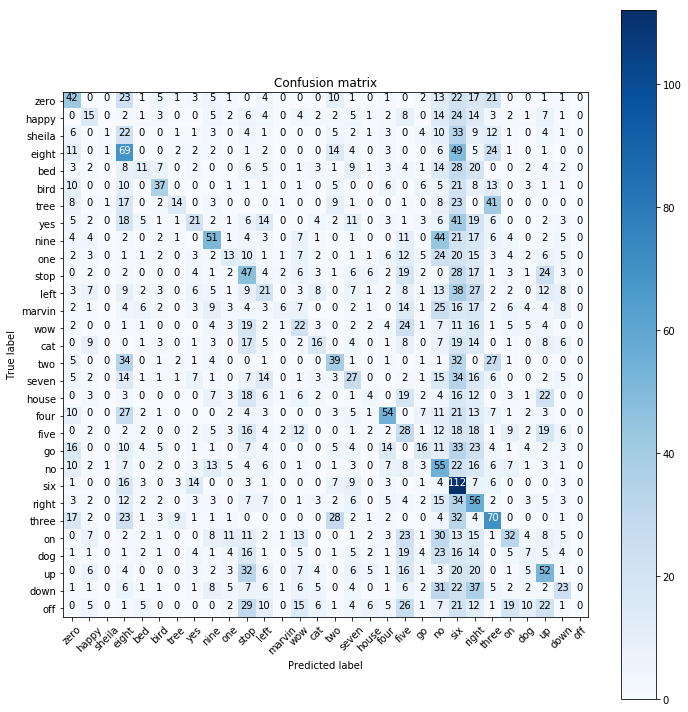

In [70]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), labels)

In [297]:
len(y_test), len(y_pred)

(100, 100)